### Time to get your hands dirty! Cloning quasars
Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

- Download the SDSS quasar data
- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)
- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

In [1]:
import numpy as np
from astroML.datasets import fetch_dr7_quasar
from matplotlib import pyplot as plt
import scipy.stats
import scipy.interpolate as interpolate
from scipy.interpolate import splev, splrep
import astropy

### 1. Plotting Histogram and PDF of the data

Firstly, we analyze the data plotting their distribution. Using rv.histogram, it is also possible to obtain the corresponding pdf.

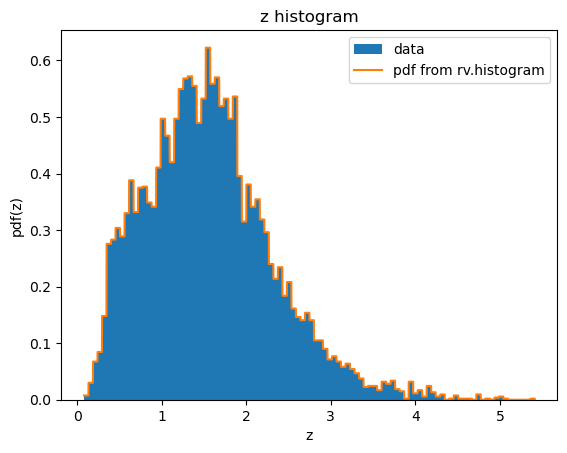

In [2]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']
z_hist = np.histogram(z, bins = 100)
z_dist = scipy.stats.rv_histogram(z_hist)

z_lin = np.linspace(min(z), max(z), 10000)

ax = plt.gca()
plt.hist(z, bins = 100, density = True, label = 'data')
ax.plot(z_lin, z_dist.pdf(z_lin), label = 'pdf from rv.histogram')
plt.title('z histogram')
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.legend()
plt.show()

### 2. Rejection Sampling

As a first method to sample values following the same distribution (aka: cloning the quasars) we can use the reverse sampling. Therefore, we create a box, between the minimum z to the maximum z for the x-axis, and between $0$ and $0.7$ (over the maximum of the sampling pdf) for the y-axis. We then sample points in this box uniformly and save only the ones that lie under the pdf line.

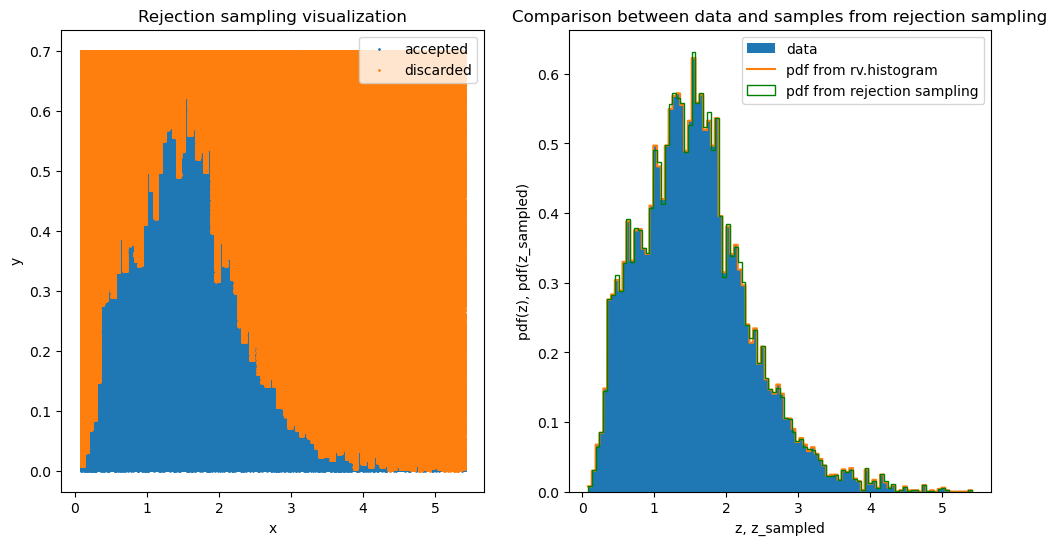

In [3]:
x = np.random.uniform(min(z),max(z),1000000)
y = np.random.uniform(0, 0.7,1000000)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
ax.scatter(x[y<z_dist.pdf(x)],y[y<z_dist.pdf(x)], s = 0.9, label ='accepted')
ax.scatter(x[y>z_dist.pdf(x)],y[y>z_dist.pdf(x)], s = 0.9, label = 'discarded')
plt.title('Rejection sampling visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc = 'upper right')

goodpoints = x[y<z_dist.pdf(x)]
ax = fig.add_subplot(122)
plt.hist(z, bins = 100, density = True, label = 'data')
ax.plot(z_lin, z_dist.pdf(z_lin), label = 'pdf from rv.histogram')
plt.hist(goodpoints,bins=100,density=True,histtype='step', color = 'green', label = 'pdf from rejection sampling')
plt.title('Comparison between data and samples from rejection sampling')
plt.xlabel('z, z_sampled')
plt.ylabel('pdf(z), pdf(z_sampled)')
plt.legend()
plt.show()

### 3. Inverse Transform Sampling

Another method to clone a distribution is the inverse transform sampling. In this case, we recover the ppf of the data and directly sample from it the new data. In order to do so, we need therefore to compute the CDF and the PPF of the quasars.

#### 3.1 CDF

Firstly, we compute the CDF. Then, we interpolate the cdf in order to inverse the resulting interpolation and obtain the PPF. To check that the interpolated CDF is correct, I compared it with the one obtained from the histogram and from rv.histogram

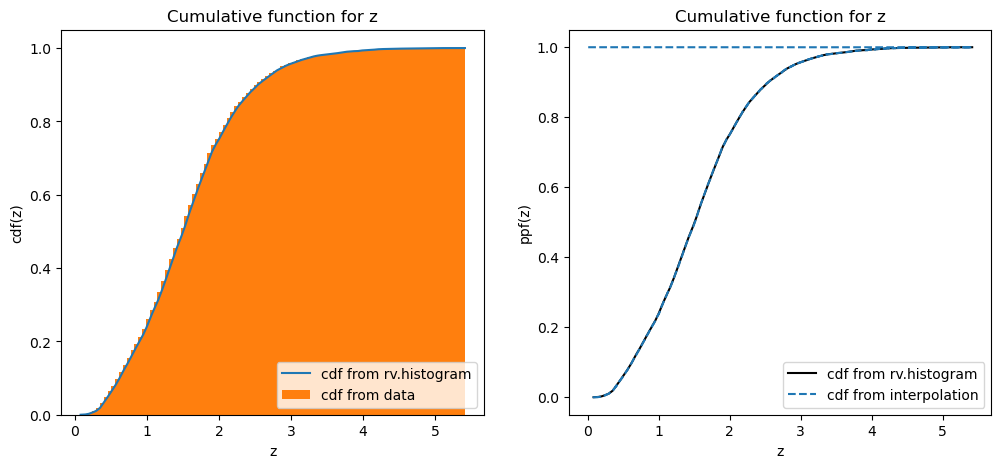

In [4]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(121)
ax.plot(z_lin, z_dist.cdf(z_lin), label = 'cdf from rv.histogram')
plt.hist(z, bins = 100, density = True, cumulative = True, label = 'cdf from data')
plt.title('Cumulative function for z')
plt.xlabel('z')
plt.ylabel('cdf(z)')
plt.legend()

z_cumulative = np.linspace(0,1, 10000)
z.sort()
tck = interpolate.splrep(z_cumulative, z) 

Pz_cumulative = np.linspace(0,1, 10000)
z_sample = interpolate.splev(Pz_cumulative, tck)

ax = fig.add_subplot(122)
ax.plot(z_lin, z_dist.cdf(z_lin), label = 'cdf from rv.histogram', color = 'black')
plt.plot(tck[1], tck[0], label = 'cdf from interpolation', linestyle = '--') 
plt.title('Cumulative function for z')
plt.xlabel('z')
plt.ylabel('ppf(z)')
plt.legend()
plt.show()

#### 3.2 PPF

We can also check that the interpolation worked also for the ppf, using rv.histogram

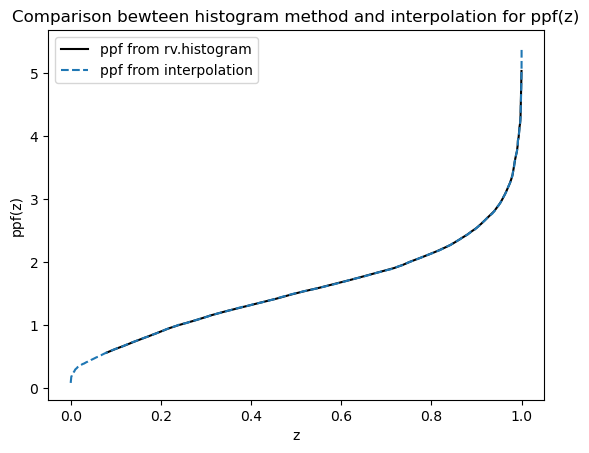

In [5]:
ax = plt.gca()
ax.plot(z_lin, z_dist.ppf(z_lin), label='ppf from rv.histogram', color = 'black')
plt.plot(Pz_cumulative, z_sample, label='ppf from interpolation', linestyle = '--')
plt.title('Comparison bewteen histogram method and interpolation for ppf(z)')
plt.xlabel('z')
plt.ylabel('ppf(z)')
plt.legend()
plt.show()

#### 3.3 Resulting samples

After obtaining the ppf, we can use it to directly clone the distribution, without rejecting any point.

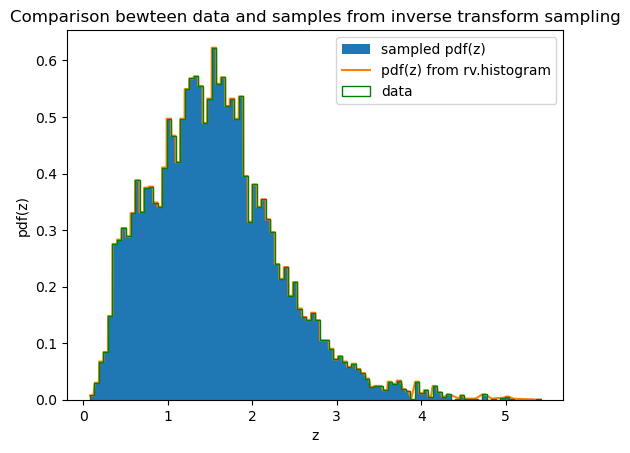

In [6]:
plt.hist(z_sample, bins = 100, density = True, label = 'sampled pdf(z)')
plt.plot(z, z_dist.pdf(z), label = 'pdf(z) from rv.histogram')
plt.hist(z, bins = 100, density = True, histtype='step',color='green', label='data')
plt.title('Comparison bewteen data and samples from inverse transform sampling')
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.legend()
plt.show()

### 4. Theorethical Quasar Distribution

We can also check whether the observed distribution for quasar corresponds to the theoretical one.

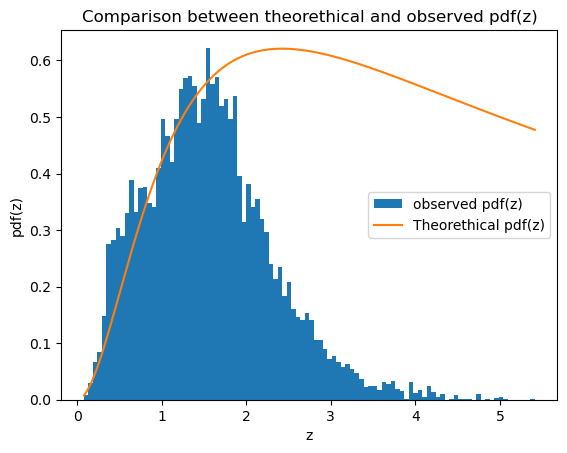

In [7]:
#tentativo di ricavare la distribuzione delle quasar
cosmo = astropy.cosmology.Planck18
#uso il differential comoving volume perché mi serve il dv, non tutto il volume sotteso
distribution = cosmo.differential_comoving_volume(z_lin).value
distribution = distribution/(sum(distribution))

plt.hist(z, bins = 100, density = True, label = 'observed pdf(z)')
plt.plot(z_lin, 1e4/2*distribution, label = 'Theorethical pdf(z)') #normalizzazione per confrontare
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.title('Comparison between theorethical and observed pdf(z)')
plt.legend();

Actually, we observe that the theorethical distribution and the observed one are comparable only at lower redshifts.